In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_12.csv")


In [9]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["gridRows"] = dataFrame["gridRows"].astype(int)
dataFrame["gridCols"] = dataFrame["gridCols"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["commCreated"] = dataFrame["commCreated"].astype(int)
dataFrame["avgTimePerAllreduce"] = pd.to_numeric(dataFrame["avgTimePerAllreduce"], errors="coerce")
dataFrame["finalGlobal"] = pd.to_numeric(dataFrame["finalGlobal"], errors="coerce")
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Topologies:", dataFrame["topology"].unique())
print("Proc counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(12)


Loaded rows: 96
Topologies: ['cart' 'torus' 'graph' 'star']
Proc counts: [2, 4, 6, 8, 9, 16, 32, 64]


,testType,topology,gridRows,gridCols,numProcesses,commCreated,avgTimePerAllreduce,finalGlobal,runIndex,mpiEnv
0,MPI_12,cart,1,2,2,1,0.000001,6.00008,1,PROCS=2
1,MPI_12,torus,1,2,2,1,0.000000,6.00008,1,PROCS=2
2,MPI_12,graph,0,0,2,1,0.000000,6.00008,1,PROCS=2
3,MPI_12,star,0,0,2,1,0.000000,6.00008,1,PROCS=2
4,MPI_12,cart,1,2,2,1,0.000001,6.00008,2,PROCS=2
5,MPI_12,torus,1,2,2,1,0.000000,6.00008,2,PROCS=2
6,MPI_12,graph,0,0,2,1,0.000000,6.00008,2,PROCS=2
7,MPI_12,star,0,0,2,1,0.000000,6.00008,2,PROCS=2
8,MPI_12,cart,1,2,2,1,0.000001,6.00008,3,PROCS=2
9,MPI_12,torus,1,2,2,1,0.000001,6.00008,3,PROCS=2


In [10]:
grouped = dataFrame.groupby(["topology","numProcesses"], as_index=False).agg(
    median=("avgTimePerAllreduce","median"),
    mean=("avgTimePerAllreduce","mean"),
    std=("avgTimePerAllreduce","std"),
    count=("avgTimePerAllreduce","count")
)
grouped["std"] = grouped["std"].fillna(0.0)
grouped = grouped.sort_values(["topology","numProcesses"]).reset_index(drop=True)
grouped.head(12)


,topology,numProcesses,median,mean,std,count
0,cart,2,0.000001,0.000001,0.000000e+00,3
1,cart,4,0.000001,0.000001,5.773503e-07,3
2,cart,6,0.000002,0.000002,0.000000e+00,3
3,cart,8,0.000002,0.000002,0.000000e+00,3
4,cart,9,0.000002,0.000002,0.000000e+00,3
5,cart,16,0.002928,0.002942,1.933805e-04,3
6,cart,32,0.014933,0.015092,3.491738e-04,3
7,cart,64,0.049357,0.049523,5.738731e-04,3
8,graph,2,0.000000,0.000000,0.000000e+00,3
9,graph,4,0.000001,0.000001,0.000000e+00,3


In [11]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for topologyVal, sub in groupedDf.groupby("topology"):
        baseRow = sub[sub["numProcesses"]==2]
        if baseRow.empty:
            continue
        baseTime = float(baseRow["median"].values[0])
        sf = sub.copy()
        sf["speedup"] = baseTime / sf["median"]
        sf["efficiency"] = sf["speedup"] / sf["numProcesses"]
        frames.append(sf)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perf = computeSpeedupEfficiency(grouped)
perf.head(12)


,topology,numProcesses,median,mean,std,count,speedup,efficiency
0,cart,2,0.000001,0.000001,0.000000e+00,3,1.000000,5.000000e-01
1,cart,4,0.000001,0.000001,5.773503e-07,3,1.000000,2.500000e-01
2,cart,6,0.000002,0.000002,0.000000e+00,3,0.500000,8.333333e-02
3,cart,8,0.000002,0.000002,0.000000e+00,3,0.500000,6.250000e-02
4,cart,9,0.000002,0.000002,0.000000e+00,3,0.500000,5.555556e-02
5,cart,16,0.002928,0.002942,1.933805e-04,3,0.000342,2.134563e-05
6,cart,32,0.014933,0.015092,3.491738e-04,3,0.000067,2.092681e-06
7,cart,64,0.049357,0.049523,5.738731e-04,3,0.000020,3.165711e-07
8,graph,2,0.000000,0.000000,0.000000e+00,3,NaN,NaN
9,graph,4,0.000001,0.000001,0.000000e+00,3,0.000000,0.000000e+00


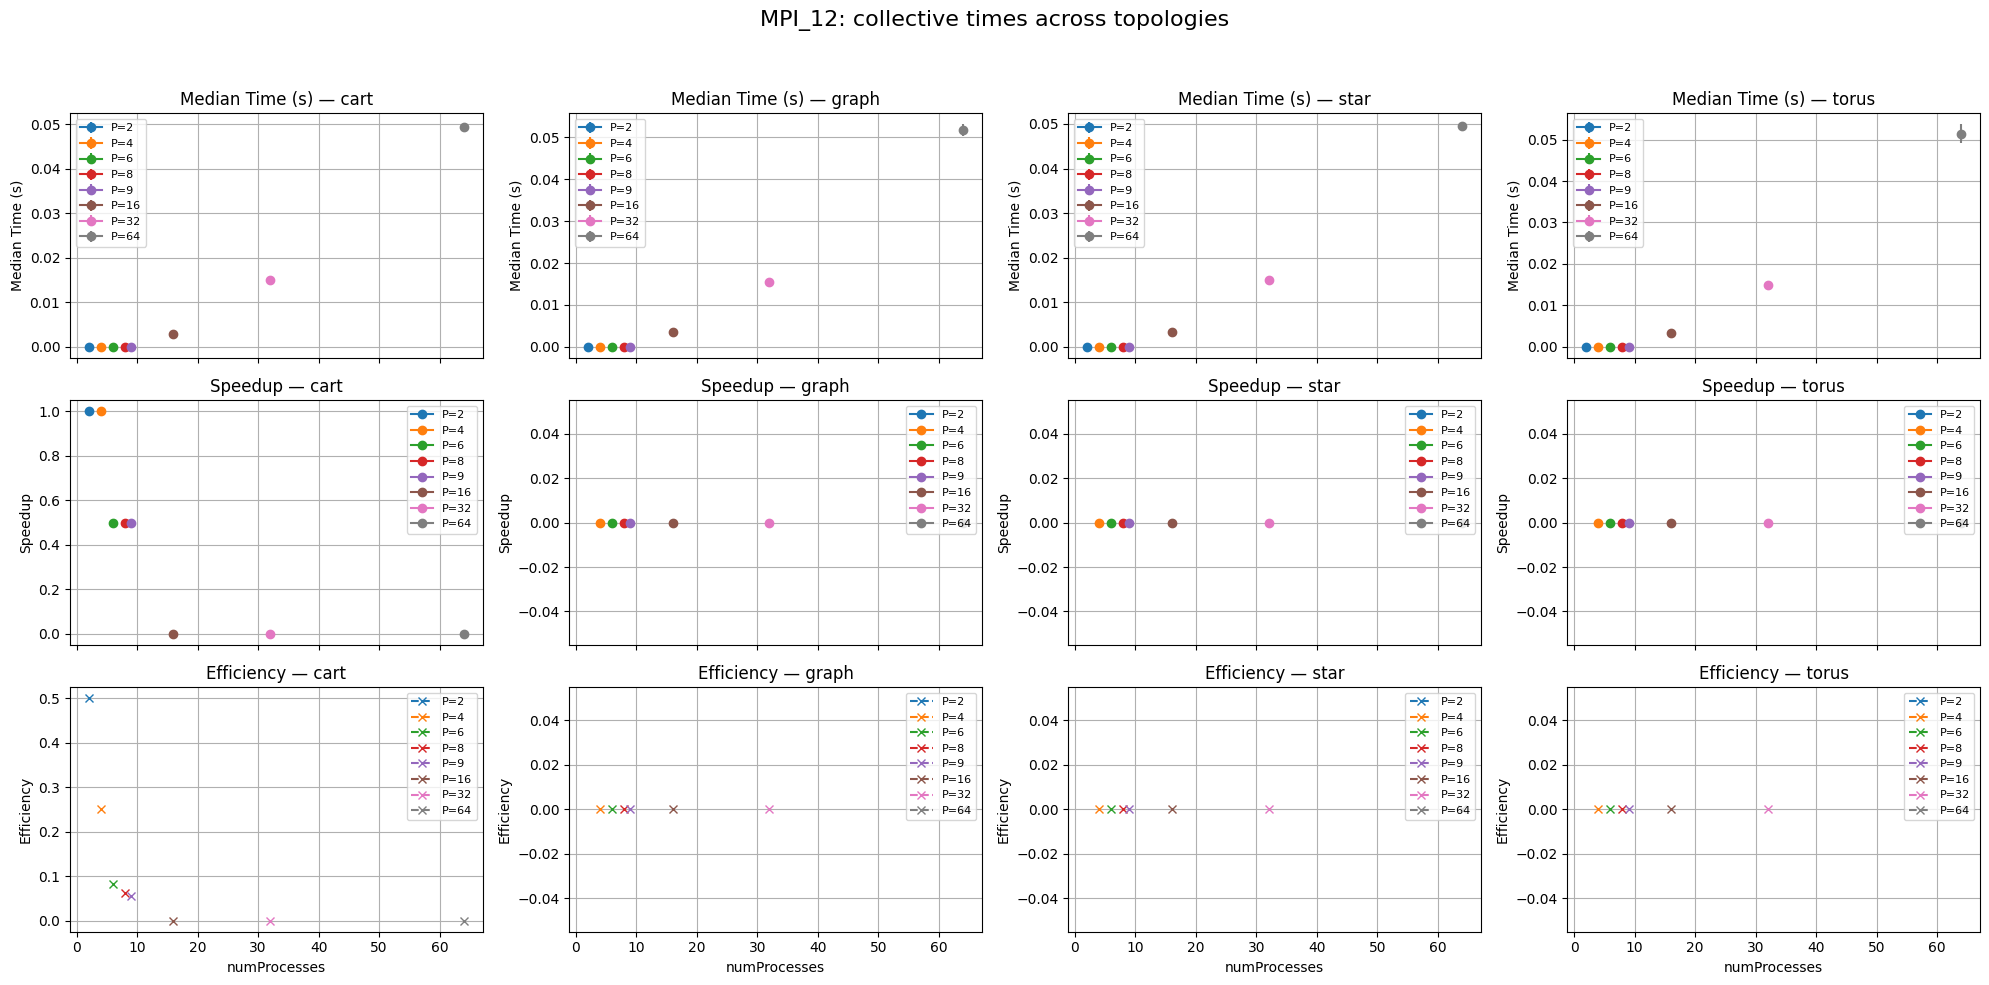

In [12]:
metrics = ["median","speedup","efficiency"]
metricLabels = {"median":"Median Time (s)","speedup":"Speedup","efficiency":"Efficiency"}

topologies = sorted(perf["topology"].unique())
procCounts = sorted(perf["numProcesses"].unique())

fig, axes = plt.subplots(len(metrics), max(1,len(topologies)), figsize=(5*max(1,len(topologies)), 10), sharex=True)
if len(topologies) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, topo in enumerate(topologies):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for procVal in sorted(perf["numProcesses"].unique()):
            sub = perf[(perf["topology"]==topo) & (perf["numProcesses"]==procVal)].sort_values("numProcesses")
            if sub.empty: continue
            anyPlotted = True
            x = sub["numProcesses"].values
            y = sub[metric].values
            if metric == "median":
                yerr = sub["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"P={procVal}")
            else:
                linestyle = '-' if metric=='speedup' else '--'
                markerStyle = 'o' if metric=='speedup' else 'x'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"P={procVal}")
        if not anyPlotted:
            ax.text(0.5,0.5,'no data',ha='center',va='center')
        ax.set_title(f"{metricLabels[metric]} — {topo}")
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_12: collective times across topologies", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [13]:
display(grouped)


,topology,numProcesses,median,mean,std,count
0,cart,2,0.000001,1.000000e-06,0.000000e+00,3
1,cart,4,0.000001,1.333333e-06,5.773503e-07,3
2,cart,6,0.000002,2.000000e-06,0.000000e+00,3
3,cart,8,0.000002,2.000000e-06,0.000000e+00,3
4,cart,9,0.000002,2.000000e-06,0.000000e+00,3
5,cart,16,0.002928,2.942000e-03,1.933805e-04,3
6,cart,32,0.014933,1.509167e-02,3.491738e-04,3
7,cart,64,0.049357,4.952333e-02,5.738731e-04,3
8,graph,2,0.000000,0.000000e+00,0.000000e+00,3
9,graph,4,0.000001,1.000000e-06,0.000000e+00,3
